In [0]:
%tensorflow_version 1.x
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.models import Model
from keras.layers import Conv2D, MaxPool2D,Dropout, Dense, Input,GlobalAveragePooling2D, AveragePooling2D,Flatten,Activation
from keras.layers.normalization import BatchNormalization
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam,SGD,Adamax
from keras.callbacks import LearningRateScheduler
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.layers.merge import concatenate
import tensorflow as tf
from keras.callbacks import ReduceLROnPlateau
#!pip install tensorflow==2.0.0

TensorFlow 1.x selected.


Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
directory_root = '/content/drive/My Drive/TugasInceptionV4/'

In [0]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, tuple((224,224)))   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [0]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:200]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".jpeg") == True or image_directory.endswith(".png") == True or image_directory.endswith(".JPG") == True :
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing Tomato___Bacterial_spot ...
[INFO] Processing Tomato___Septoria_leaf_spot ...
[INFO] Processing Tomato___Late_blight ...
[INFO] Processing Tomato___Early_blight ...
[INFO] Processing Tomato___Leaf_Mold ...
[INFO] Processing Tomato___Tomato_Yellow_Leaf_Curl_Virus ...
[INFO] Image loading completed


In [0]:
image_size = len(image_list)
image_size

1200

In [0]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

In [0]:
print(label_binarizer.classes_)

['Tomato___Bacterial_spot' 'Tomato___Early_blight' 'Tomato___Late_blight'
 'Tomato___Leaf_Mold' 'Tomato___Septoria_leaf_spot'
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus']


In [0]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0

In [0]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list,image_labels, test_size=0.2 , random_state =42) 

[INFO] Spliting data to train, test


In [0]:
#Define a function for a convolutional layer with batch normalization
#The commands in this function will be used very much, so it's simpler to define this function once. 
def conv(input_, filters_, kernel_, strides_, bias_, padding_):
    conv_ = Conv2D(filters=filters_, kernel_size=kernel_, strides=strides_, use_bias=bias_, padding=padding_)(input_)
    #The batch normalization helps to prevent overfitting and better learning results by removing the covariance shift.
    conv_ = BatchNormalization(axis = -1, momentum = 0.9997, scale = False)(conv_)
    conv_ = Activation("relu")(conv_)
    return conv_

In [0]:
#All kinds of inception networks starting with a stem. The stem preprocesses 
#the input.
def stem(input_):
    #First convolutional block
    stem_ = conv(input_, 32, (3,3), (2,2), False, "valid")
    stem_ = conv(stem_, 32, (1,3), (1,1), False, "same")
    stem_ = conv(stem_, 32, (3,1), (1,1), False, "same")
    stem_ = conv(stem_, 64, (1,3), (1,1), False, "same")
    stem_ = conv(stem_, 64, (3,1), (1,1), False, "same")
    
    #Instead of going deeper the network will becoming wider!
    stem_1 = conv(stem_, 96, (3,3), (2,2), False, "valid")
    stem_2 = MaxPool2D(pool_size=(3,3), strides=(2,2), padding="valid")(stem_)
    #Concatenate stem_1 and stem_2
    stem_ = concatenate([stem_1, stem_2], axis = -1)
    
    #In the next block we will also parallize two convolutional blocks
    #Here I reuse the two variable names from above
    stem_1 = conv(stem_, 64, (1,1), (1,1), False, "same")
    stem_1 = conv(stem_1, 64, (7,1), (1,1), False, "same")
    stem_1 = conv(stem_1, 64, (1,7), (1,1), False, "same")
    stem_1 = conv(stem_1, 96, (1,3), (1,1), False, "valid")
    stem_1 = conv(stem_1, 96, (3,1), (1,1), False, "valid")
    stem_2 = conv(stem_, 64, (1,1), (1,1), False, "same")
    stem_2 = conv(stem_2, 96, (3,3), (1,1), False, "valid")
    #Concatenate stem_1 and stem_2
    stem_ = concatenate([stem_1, stem_2], axis = -1)
    
    #Third concatenation block
    #Reuse stem_1 and stem_2
    stem_1 = MaxPool2D(pool_size=(1,1), strides=(2,2), padding="valid")(stem_)
    stem_2 = stem_1 = conv(stem_, 192, (3,3), (1,1), False, "valid")
    #Concatenate stem_1 and stem_2
    stem_ = concatenate([stem_1, stem_2], axis = -1)
    
    return stem_  

In [0]:
def inception_A(input_):
    #In this block we parallize four convolutional blocks
    #First
    A_1 = conv(input_, 64, (1,1), (1,1), False, "same")
    A_1 = conv(A_1, 96, (1,3), (1,1), False, "same")
    A_1 = conv(A_1, 96, (3,1), (1,1), False, "same")
    A_1 = conv(A_1, 96, (1,3), (1,1), False, "same")
    
    
    #Second
    A_2 = conv(input_, 64, (1,1), (1,1), False, "same")
    A_2 = conv(A_2, 96, (1,3), (1,1), False, "same")
    A_2 = conv(A_2, 96, (3,1), (1,1), False, "same")
    
    #Third
    A_3 = conv(input_, 96, (1,1), (1,1), False, "same")
    
    #Fourth
    A_4 = AveragePooling2D((3, 3), strides = (1, 1), padding = "same")(input_)
    A_4 = conv(A_4, 96, (1,1), (1,1), False, "same")
    
    A = concatenate([A_1, A_2, A_3, A_4], axis=-1)
    
    return A    
    

In [0]:
def inception_B(input_):
    #Similiar to A
    #In this block we also parallize four convolutional blocks
    
    #First
    B_1 = conv(input_, 192, (1,1), (1,1), False, "same")
    B_1 = conv(B_1, 192, (1,7), (1,1), False, "same")
    B_1 = conv(B_1, 224, (7,1), (1,1), False, "same")
    B_1 = conv(B_1, 224, (1,7), (1,1), False, "same")
    B_1 = conv(B_1, 256, (7,1), (1,1), False, "same")
    
    #Second
    B_2 = conv(input_, 192, (1,1), (1,1), False, "same")
    B_2 = conv(B_2, 224, (7,1), (1,1), False, "same")
    B_2 = conv(B_2, 256, (1,7), (1,1), False, "same")
    
    #Third
    B_3 = conv(input_, 384, (1,1), (1,1), False, "same")
    
    #Fourth
    B_4 = AveragePooling2D((3, 3), strides = (1, 1), padding = "same")(input_)
    B_4 = conv(B_4, 128, (1,1), (1,1), False, "same")
    
    B = concatenate([B_1, B_2, B_3, B_4], axis=-1)
    
    return B    

In [0]:
def inception_C(input_):
    #This block is different to the structures of the other two blocks
    
    #First
    C_1 = conv(input_, 384, (1,1), (1,1), False, "same")
    C_1 = conv(C_1, 448, (1,3), (1,1), False, "same")
    C_1 = conv(C_1, 512, (3,1), (1,1), False, "same")
    #Split it up again
    C_11 = conv(C_1, 256, (1,3), (1,1), False, "same")
    C_12 = conv(C_1, 256, (3,1), (1,1), False, "same")
    #Concatenate it again
    C_1 = concatenate([C_11, C_12], axis=-1)
    
    #Second
    C_2 = conv(input_, 384, (1,1), (1,1), False, "same")
    #Split it up again
    C_21 = conv(C_2, 256, (1,3), (1,1), False, "same")
    C_22 = conv(C_2, 256, (3,1), (1,1), False, "same")
    #Concatenate it again
    C_2 = concatenate([C_21, C_22], axis=-1)
    
    #Third
    C_3 = conv(input_, 256, (1,1), (1,1), False, "same")
    
    #Fourth
    C_4 = AveragePooling2D((3, 3), strides = (1, 1), padding = "same")(input_)
    C_4 = conv(C_4, 128, (1,1), (1,1), False, "same")
    
    C = concatenate([C_1, C_2, C_3, C_4], axis=-1)
    
    return C

In [0]:
def reduction_1(input_):
    #Three parallized branches
    #We must choose four parameters (k,l,m,n) depending on the used network
    #The parameters are listed in a look up table in Paper 2
    k = 192
    l = 224
    m = 256
    n = 384
    
    #First
    R_1 = conv(input_, k, (1,1), (1,1), False, "same")
    R_1 = conv(R_1, l, (1,3), (1,1), False, "same")
    R_1 = conv(R_1, l, (3,1), (1,1), False, "same")
    R_1 = conv(R_1, m, (3,3), (2,2), False, "same")
    
    #Second
    R_2 = conv(input_, n, (1,3), (2,2), False, "same")
    R_2 = conv(input_, n, (3,1), (2,2), False, "same")
    
    #Third
    R_3 = MaxPool2D(pool_size=(3,3), strides=(2,2), padding="same")(input_)
    
    R = concatenate([R_1, R_2, R_3], axis=-1)
    
    return R

In [0]:
def reduction_2(input_):
    #Second reduction module
    
    #First
    R_1 = conv(input_, 256, (1,1), (1,1), False, "same")
    R_1 = conv(R_1, 256, (1,7), (1,1), False, "same")
    R_1 = conv(R_1, 320, (7,1), (1,1), False, "same")
    R_1 = conv(R_1, 320, (3,3), (2,2), False, "same")
    
    #Second
    R_2 = conv(input_, 192, (1,1), (1,1), False, "same")
    R_2 = conv(R_2, 192, (1,1), (2,2), False, "same")
    
    #Third
    R_3 = MaxPool2D(pool_size=(3,3), strides=(2,2), padding="same")(input_)
    
    R = concatenate([R_1, R_2, R_3], axis=-1)
    
    return R

In [0]:
def pure_inception_v4(load_weights=True):
    
    starter = Input((224, 224, 3))
    
    #Start with the stem
    inc = stem(starter)
    
    #inception block A
    inc = inception_A(inc)
    inc = Dropout(0.2)(inc)
    
    #First Reduction
    inc = reduction_1(inc)
    
    #innception block B
    inc = inception_B(inc)    
    inc = Dropout(0.2)(inc)
    
    #Second Reduction
    inc = reduction_2(inc)
    
    #inception block C
    inc = inception_C(inc)
    
    #Average pooling
    inc = AveragePooling2D((3, 3))(inc)

    # Dropout
    inc = Dropout(0.2)(inc) # Keep dropout 0.2 as mentioned in the paper
    inc = Flatten()(inc)

    # Output layer
    output = Dense(units = 6 , activation = "softmax")(inc)
    
    model = Model(starter, output, name = "Inception-v4")   
        
    return model    


In [0]:
Model = pure_inception_v4()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.




In [0]:
print(Model.summary())

Model: "Inception-v4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 111, 111, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 111, 111, 32) 0           batch_normalization_1[0][0]      
_______________________________________________________________________________________

In [0]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [0]:
Model.compile(loss="binary_crossentropy", optimizer='Adam',metrics=["accuracy"])

In [0]:
history = Model.fit_generator(
    aug.flow(x_train, y_train, batch_size=4),
    steps_per_epoch=len(x_train)//4,
    epochs=100,
    validation_data=(x_test, y_test),
    max_queue_size=4*2,
    verbose=1
    )

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/100
240/240 [==============================] - 29s 122ms/step - loss: 1.6242 - accuracy: 0.7686 - val_loss: 4.2720 - val_accuracy: 0.7222
Epoch 2/100
240/240 [==============================] - 22s 91ms/step - loss: 1.3427 - accuracy: 0.7814 - val_loss: 4.3574 - val_accuracy: 0.7167
Epoch 3/100
240/240 [==============================] - 22s 90ms/step - loss: 1.5296 - accuracy: 0.7760 - val_loss: 3.7593 - val_accuracy: 0.7556
Epoch 4/100
240/240 [==============================] - 22s 90ms/step - loss: 1.0928 - accuracy: 0.7819 - val_loss: 4.0584 - val_accuracy: 0.7361
Epoch 5/100
240/240 [==============================] - 22s 91ms/step - loss: 0.4497 - accuracy: 0.8240 - val_loss: 4.0780 - val_accuracy: 0.7333
Epoch 6/100
240/240 [==============================] - 22s 90ms/step - loss: 0.3846 - accuracy: 0.8429 - val_loss: 4.1011 - val_accuracy: 0.7333
Epoch 7/100
240/240 [=============

In [0]:
print("[INFO] Calculating model accuracy")
scores = Model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
240/240 [==============================] - 2s 8ms/step
Test Accuracy: 86.11111044883728


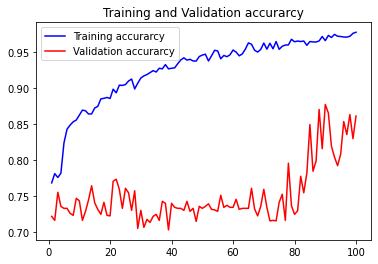

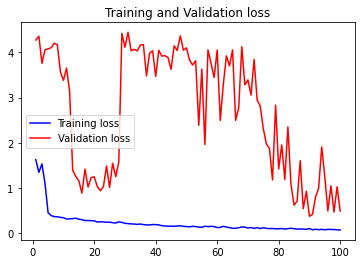

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()